In [1]:
%matplotlib inline
import numpy as np
from numpy import genfromtxt  
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

## implementation of

- Gaussian distribution function
- Expectation Maximazation Algorithm
- Akaike Information Criterion

In [2]:
def gaussian(x, mu, sig):
    '''
    returns the likelihood of a point in a one dimensional gaussian
    
    x x value(s)
    mu mean of the gaussian
    sig variance of the gaussian 
    '''
    return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))

In [3]:
# inspiration: https://www.youtube.com/watch?v=iQoXFmbXRJA
def em(data, k=1, n=1, init_mixing_coefficent=None, init_mean=None, init_variance=None):
    '''
    vanilla 1d expectation maximazation algorithm
    
    data 1d numpy array of data
    k number of normal distributions
    n number of em repetitions
    init_* initializes with these values if not None
    
    returns mixing coefficients, means, variances
    '''
    
    # ensure data are 1d ndarray
    data = np.array(data).flatten()
    
    # list of means and variances of the k normal distributions to be fitted
    # init randomly between min and max points of data
    min_data, max_data = data.min(), data.max() 
    
    if init_mixing_coefficent is None:
        prior = np.full(k, 1 / k)  # assume priors (mixing coefficents) are equal
    else:
        prior = init_mixing_coefficent
    
    if init_mean is None:
        mean = np.random.uniform(low=min_data, high=max_data, size=k)
    else:
        mean = init_mean
        
    if init_variance is None:
        variance = np.random.uniform(low=np.absolute(min_data / 2), high=np.absolute(max_data/2), size=k)
    else:
        variance = init_variance
     
    # repeat algorithm n times
    for i in range(n):
        
        p_x_b = []
        
        # loop through each distribution j
        for j in range(k):
            # calcualate for each point the generative probability that it belongs to the distribution j
            # P(x | b)
            p_x_b.append(gaussian(data, mean[j], variance[j]))
            
        # convert to numpy array
        p_x_b = np.array(p_x_b)
         
        # calculate for each point the probability that it belongs to a distribution,
        # summing up to one ('colorings of the points')
        # P(b|x)
        p_wp = p_x_b * prior.reshape(-1, 1)
        bi =  p_wp / p_wp.sum(axis=0)
         
        # reestimate means
        mean = (bi * data).sum(axis=1) / bi.sum(axis=1)
        
        # reestimate variances
        for j in range(k):
            variance[j] = (bi[j] * (data - mean[j])**2).sum() / bi[j].sum()
            
        # reestimate priors
        unique, counts = np.unique(bi.reshape(bi.shape[::-1]).argmax(axis=1), return_counts=True)
        # counts array are in the correct order the counts of points that have the max likelihood
        prior = counts / data.shape[0]
         
        
    # return means and variances
    return prior, mean, variance 

In [4]:
def aic(data, mixing_coefficent, mean, variance):
    '''
    return best model to the Akaike Information Criterion
    
    data 1dim data
    mixing_coefficents mixing coefficients / priors pi
    mean means of the gaussians mu 
    variance variances of the gaussians sigma
    '''
    
    # ensure data are flat ndarray
    data = np.array(data).flatten()
    
    # calculate K (number of parameters)
    K = len(mean) * 3 - 1  # len of prior, mean and variance should be the same
    
    # calculate log-likelihoods
    LL = 0 
        
    for pi, mu, sig in zip(mixing_coefficent, mean, variance):
        LL += pi * gaussian(data, mu, sig)
         
    LL = np.log(LL).sum()
         
    return -2 * LL + 2 * K

## Plotting functions

In [5]:
 def scatter(data):
    '''
    scatter plot of 1dim data
    data 1 dim data
    '''
    
    plt.figure(figsize=(9,2))
    plt.scatter(data, np.zeros((len(data), 1)))
    plt.yticks(())
    plt.show()
    
def plt_with_gaussians(data, mean, variance):
    '''
    scatter the data,
    and plot the given gaussian distributions
    
    data 1dim data to be scattered
    mean means of the normal distributions
    variance variances of the normal distributions
    '''
    
    plt.figure(figsize=(14, 7))
    
      # generate x values with min and max of the data
    x_values = np.linspace(data.min(), data.max(), 1001)
    # show the gaussians 
    for mu, sig in zip(mean, variance):
        plt.plot(x_values, gaussian(x_values, mu, sig))
        
    # scatter data points on x axis
    plt.scatter(data, np.zeros((len(data), 1)))
    
    plt.yticks(())
    plt.show()

### load datasets

In [6]:
def load_iris():
    '''
    Returns a column of all petal lengths.
    '''
    X = genfromtxt("./data/iris.csv", delimiter=',', skip_header=1)
    X = X[:,2]
    X = X.reshape(-1, 1)
    return X

def load_bdp():
    '''
    Returns a column of systolic and diastolic blood pressure values.
    '''
    Z = genfromtxt("./data/bdp.csv", delimiter=',', skip_header=1)
    n = Z.shape[0]
    X = np.zeros(2*n)
    X[:n] = Z[:,2]
    X[n:] = Z[:,3]
    X = X.reshape(-1,1)
    return X

def sample(pi, mu, std, n):
    '''
    Returns a column of n values drawn from a normal mixture model.
    
    Parameter
        pi  k mixing coefficients
        mu  k means
        std k standard deviations
        n   number of data points
        
    Return
        n data points randomly sampled from specified mixture. 
    '''
    y = np.random.choice(len(pi), size=n, p=pi)
    x = np.zeros((n,1))
    for i, comp in enumerate(y):
        x[i] = norm.rvs(mu[comp], std[comp])
    return x


## Examples

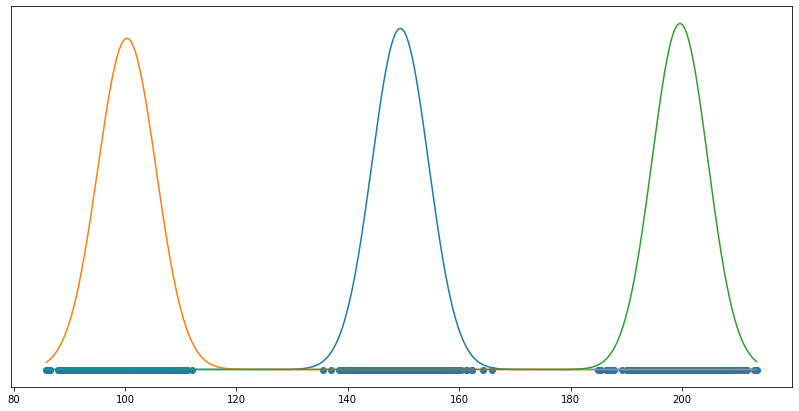

In [7]:
# generate n points from a mixture of fived normal distributions
n = 1000
mu = [100, 150, 200]
std = 5*np.ones(len(mu))
pi = np.ones(len(mu))/len(mu)
sample_x = sample(pi, mu, std, n)

priors, mu, sig = em(sample_x, 3, 10)
plt_with_gaussians(sample_x, mu, sig)

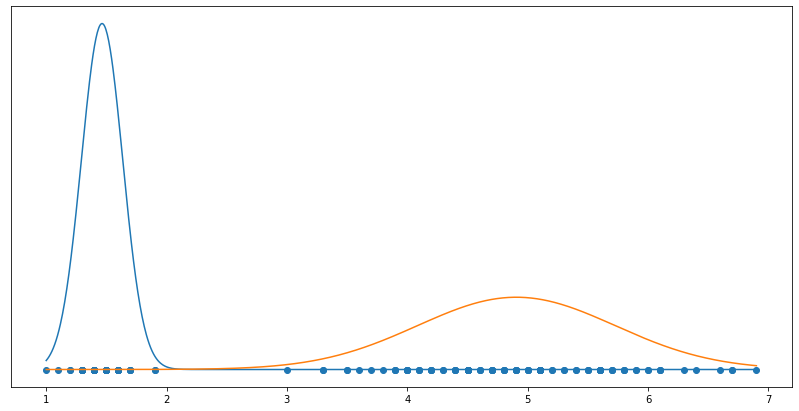

In [8]:
# load petal lengths of iris flowers
iris_x = load_iris()
priors, mu, sig = em(iris_x, 2, 10)
plt_with_gaussians(iris_x, mu, sig)

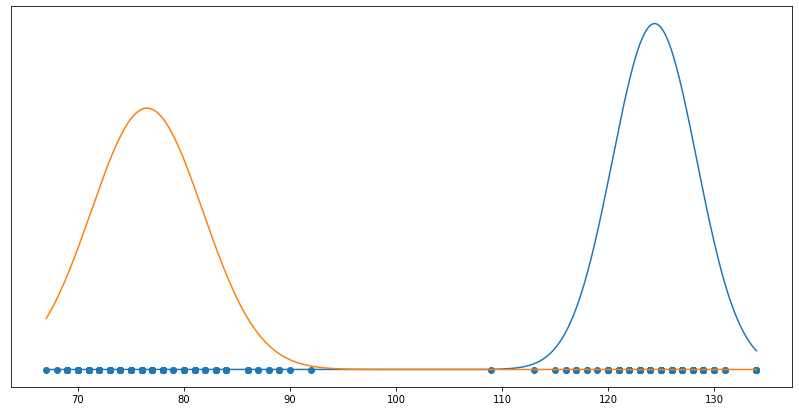

In [9]:
# load blood pressures
bdp_x = load_bdp()
priors, mu, sig = em(bdp_x, 2, 10)
plt_with_gaussians(bdp_x, mu, sig)

### compare my algorithm with sklearn's GMM

In [10]:
for j in range(1, 5):
    # sklearns EM / GMM
    gmm = GaussianMixture(n_components=j, init_params='kmeans', max_iter=100, reg_covar=1e-2)
    gmm.fit(sample_x)
     
    # my gmm 
    my_pi, my_mu, my_sig = em(sample_x, j, 100)
    sk_mu, sk_sig = sk_pi = gmm.means_.flatten(), gmm.covariances_.flatten()
    
    # print difference
    print(f'\n{j}')
    print(f'my mus = {my_mu}')
    print(f'sk mus = {sk_mu}')
    print(f'my sig = {my_sig}')
    print(f'sk sig = {sk_sig}')
    print(f'my aic = {aic(sample_x, my_pi, my_mu, my_sig)}')
    print(f'sk aic = {gmm.aic(sample_x)}')


1
my mus = [150.06413649]
sk mus = [150.06413649]
my sig = [1689.86916588]
sk sig = [1689.87916588]
my aic = 10274.283454688244
sk aic = 10274.283454705752

2
my mus = [199.71446262 124.78905718]
sk mus = [125.2937285  199.81767854]
my sig = [ 24.32799414 643.98681724]
sk sig = [673.64025316  23.2538798 ]
my aic = 9743.516871144724
sk aic = 9462.627235132646

3
my mus = [149.43478929 100.353585   199.64523232]
sk mus = [149.43478929 100.353585   199.64523232]
my sig = [25.81599364 27.37998503 25.08671951]
sk sig = [25.82599363 27.38998504 25.09671954]
my aic = 8343.508133997228
sk aic = 8311.706206428866

4
my mus = [150.42791238 199.64523233 100.353585   148.1952481 ]
sk mus = [103.89585449 199.64523232 149.43478929  97.2880158 ]
my sig = [28.35821448 25.08671943 27.37998503 19.87550698]
sk sig = [14.38853401 25.09671954 25.82599363 18.38498127]
my aic = 8447.988565851376
sk aic = 8318.257414046579


# conduct experiment of the assignment

In [11]:
# conduct experiment
def select_gmm(data, log='v'):
    '''
    selects the best model according to aic for k = {1..15}
    
    data 1dim data array
    log [default='v(erbose)', 'vp (verbose-plot)', n(one)]
    '''
    
    # best model and aic
    best = None
    
    for k in range(1, 16):
        # generate gmm
        pi, mu, sig = em(data, k, n=10)  # let em loop n times
        
        # calc aic
        t_aic = aic(data, pi, mu, sig)
        
        # create model dict
        model = {
            'k': k,
            'pi': pi, 
            'mu': mu, 
            'sig': sig, 
            'aic': t_aic
        }
        
        # print model if is verbose
        if log == 'v' or log == 'vp': 
            print(k, t_aic)
        if log == 'vp':
            plt_with_gaussians(data, mu, sig)
        
        # compare current looping model to best model
        if best == None or t_aic > best['aic']:
            best = model
            
            if log == 'v' or log == 'vp':
                print('This is the new best model according to aic!')
        
            
    return best
        
def sel_plt(data):
    '''
    select and plot best model according to aic
    
    data 1dim data array
    '''
    
    model = select_gmm(data, log='vp')
    print('best model:')
    plt_with_gaussians(data, model['mu'], model['sig'])

1 10274.283454688244


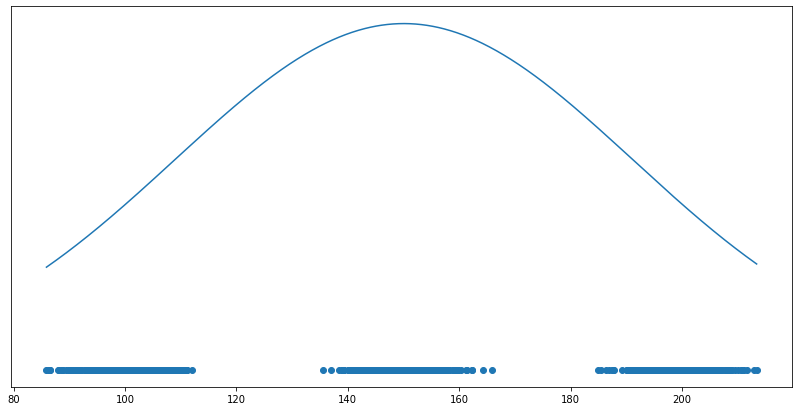

This is the new best model according to aic!
2 10089.559385035285


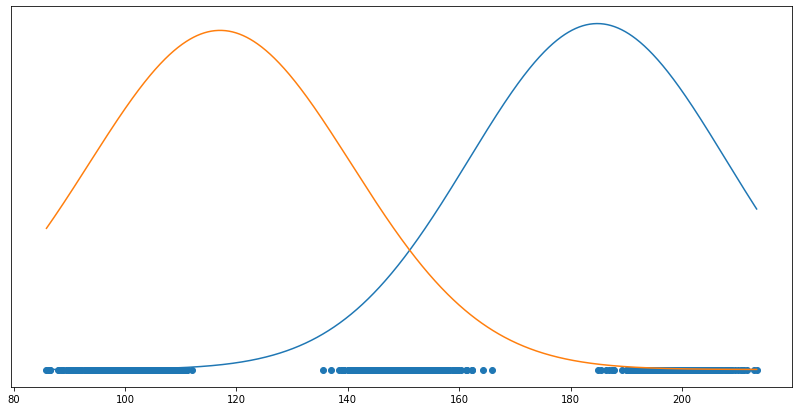

3 8326.37299188123


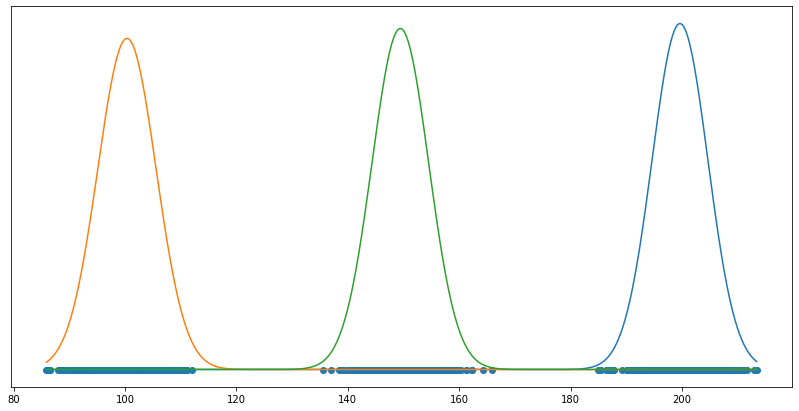

4 8472.635973750379


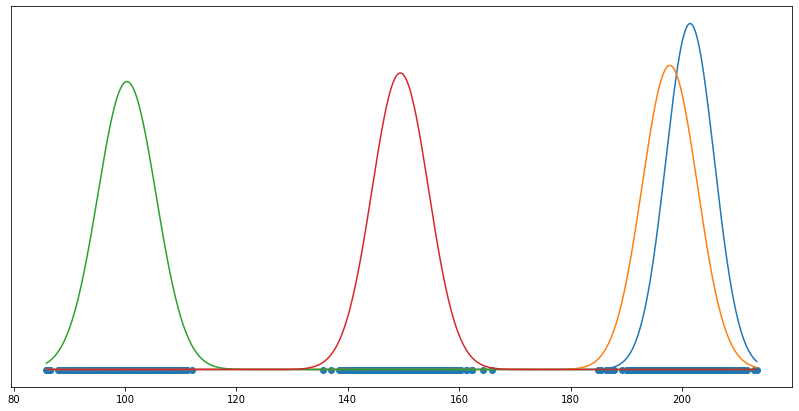

5 8655.219008608252


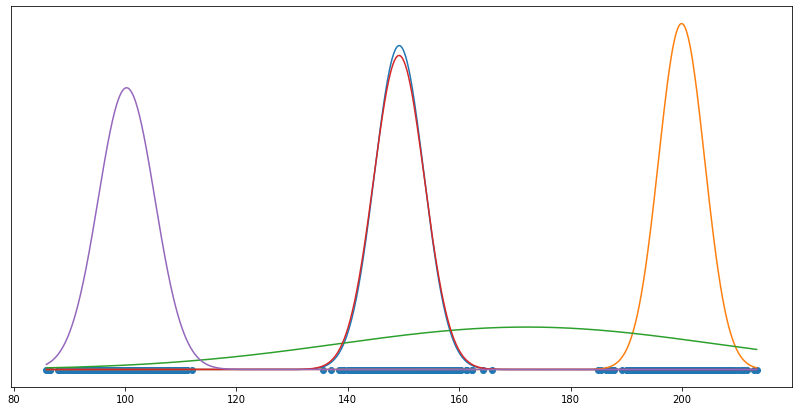

6 8492.445161357437


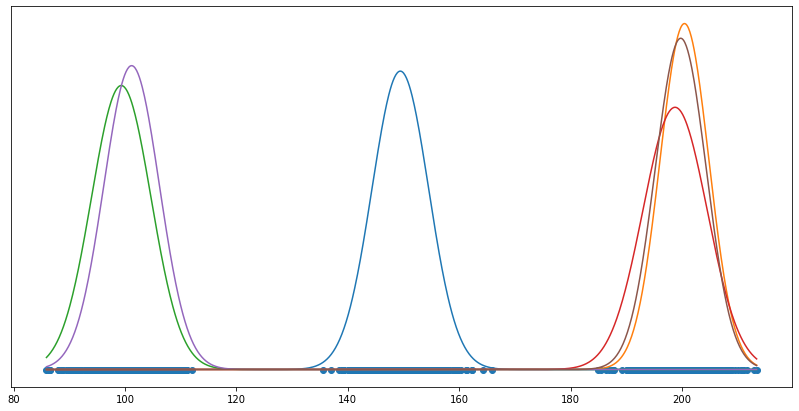

7 8457.390720790558


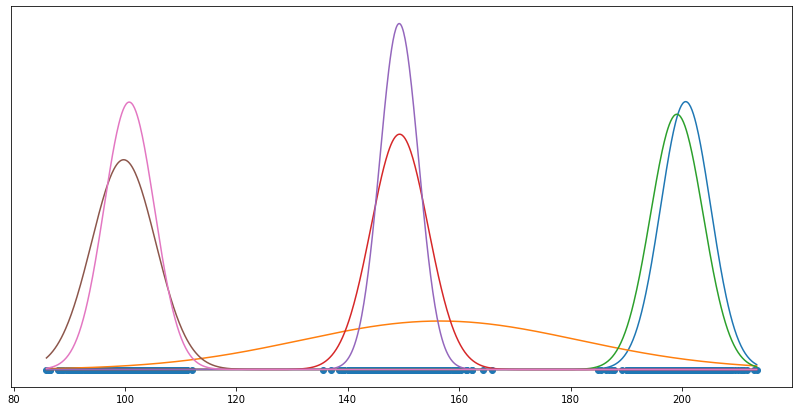

8 8428.903335625904


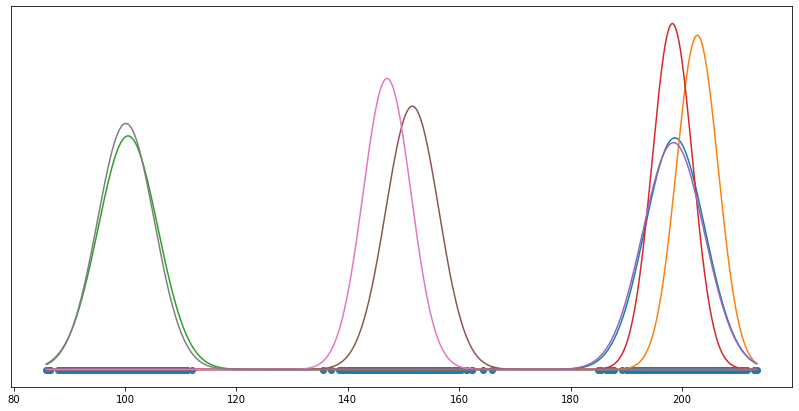

9 8787.128143122567


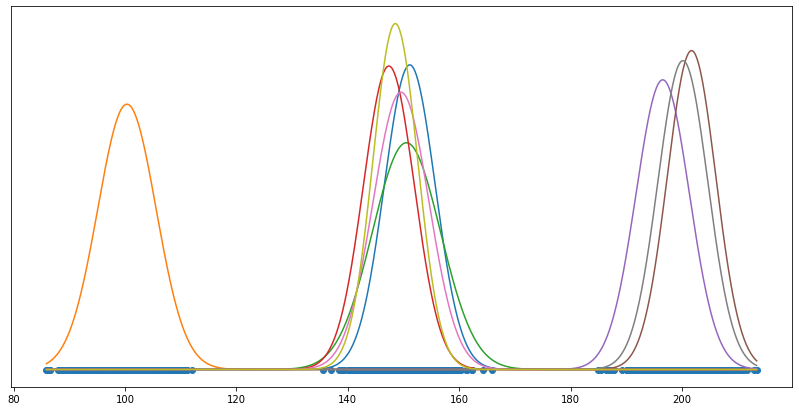

10 8521.988552827035


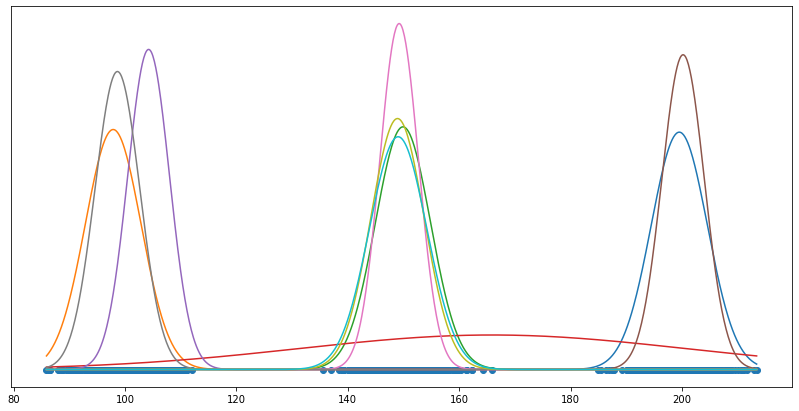

11 8524.859973597268


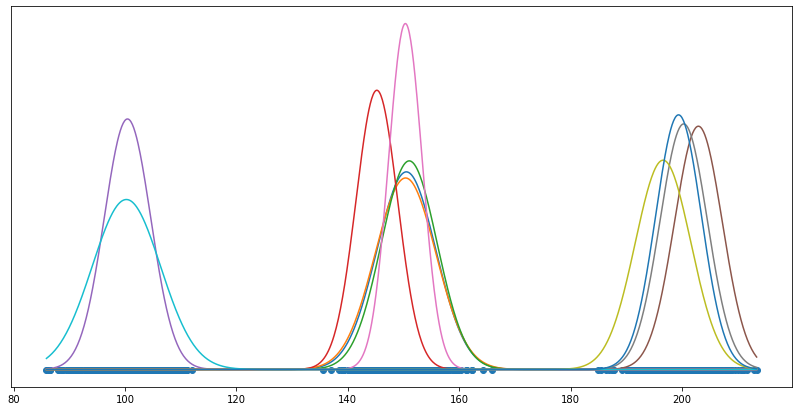

12 8432.402234473422


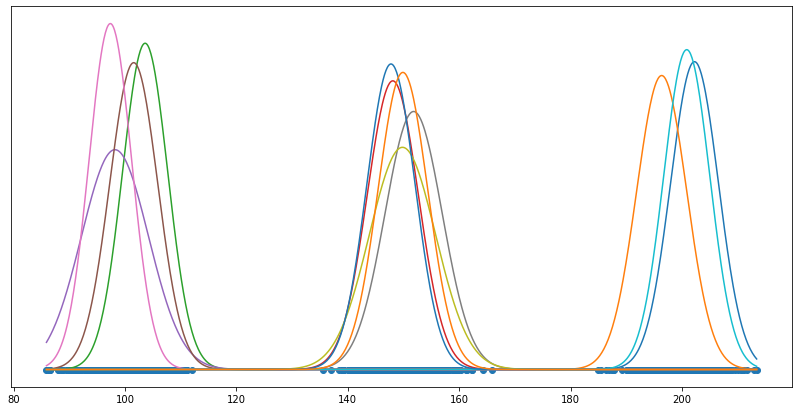

13 8504.518170472555


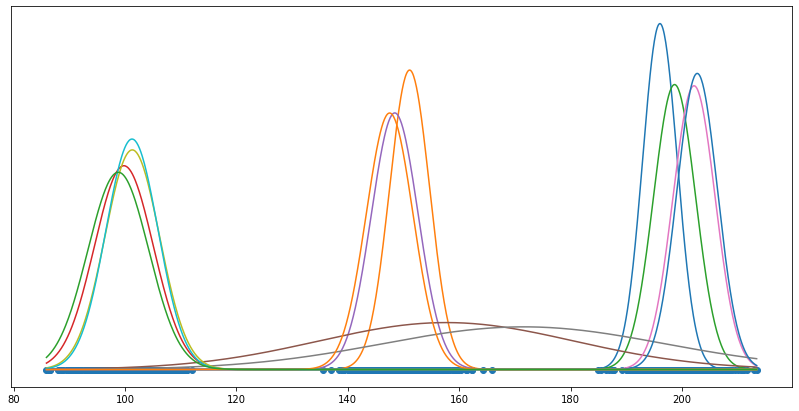

14 8382.887085968458


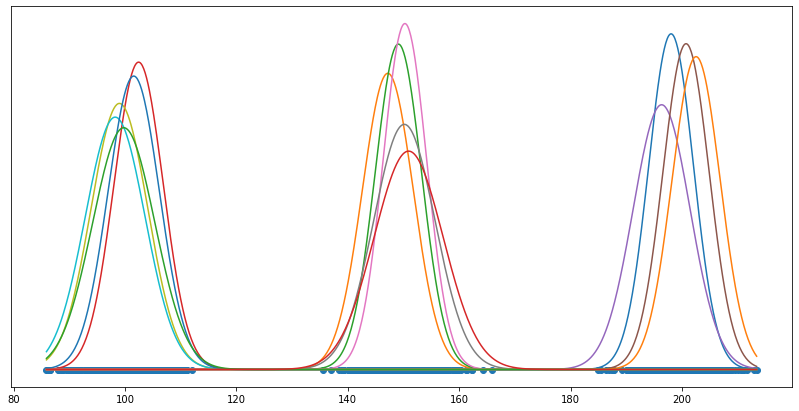

15 8539.527932591169


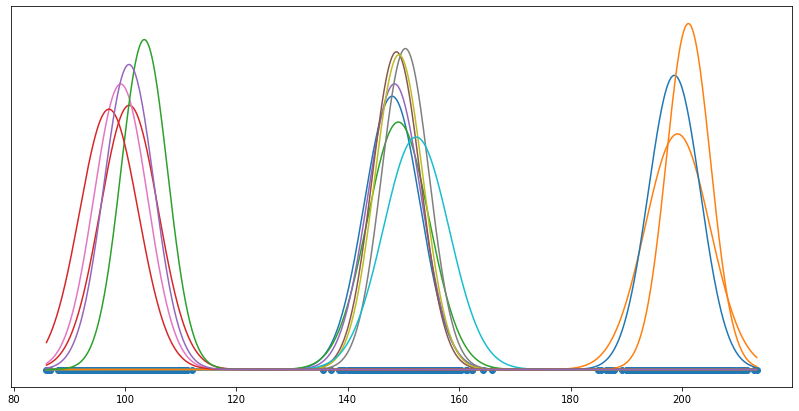

best model:


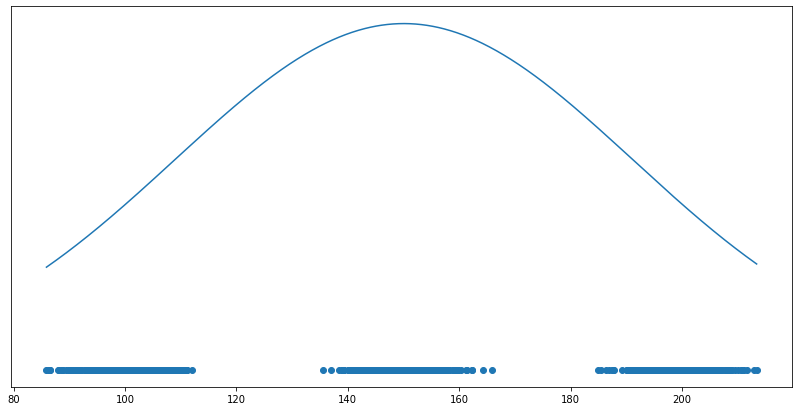

In [12]:
sel_plt(sample_x)

1 599.0248904869825


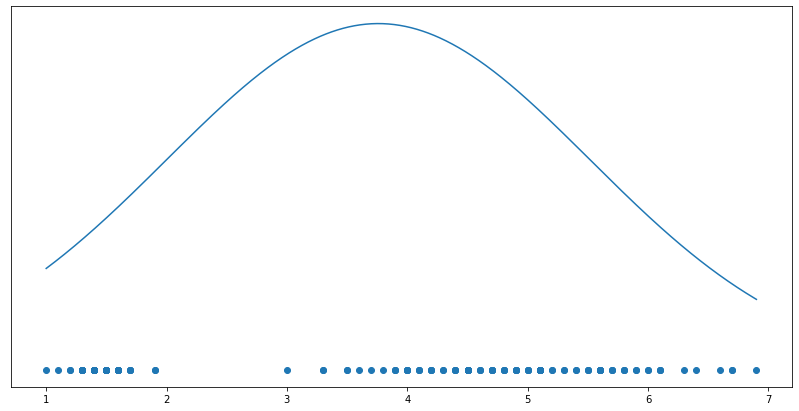

This is the new best model according to aic!
2 555.746352772057


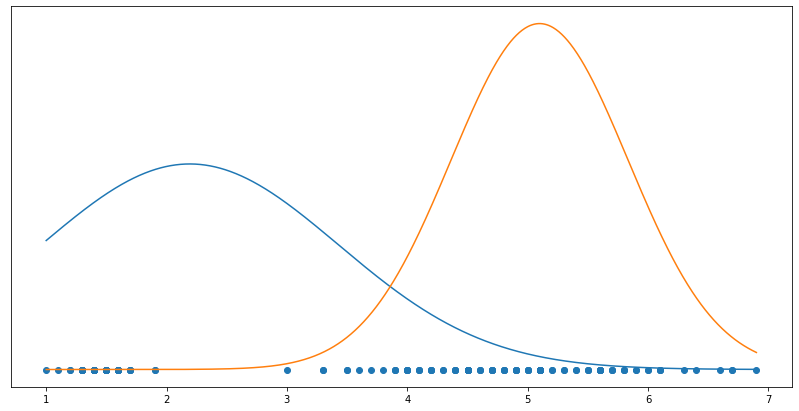

3 421.0286859428387


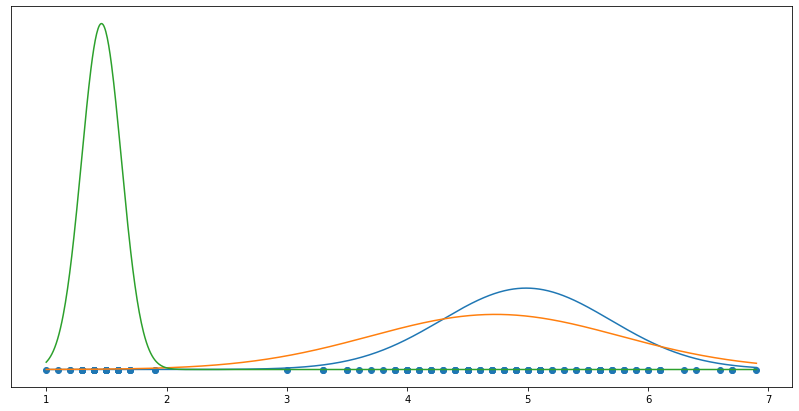

4 450.011684135128


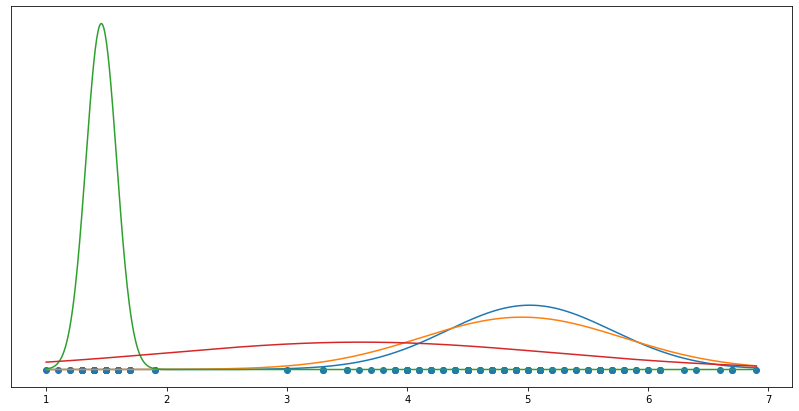

5 440.81342840651143


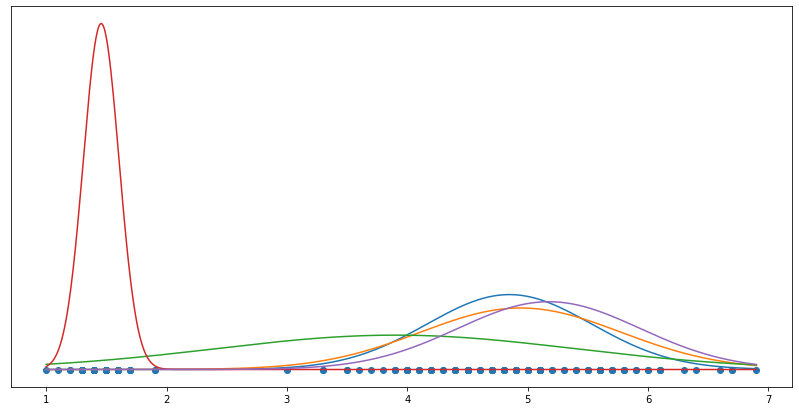

6 482.5529520466085


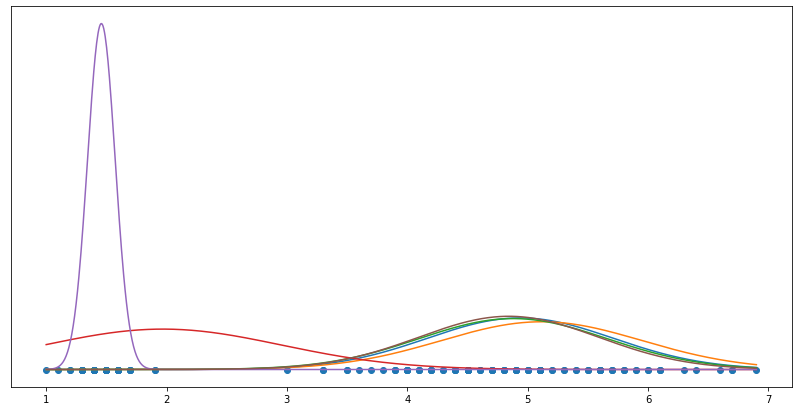

7 465.3082076606088


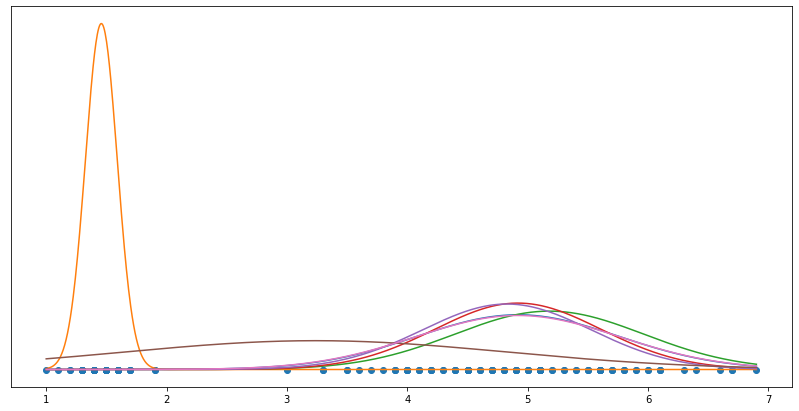

8 450.5075255072986


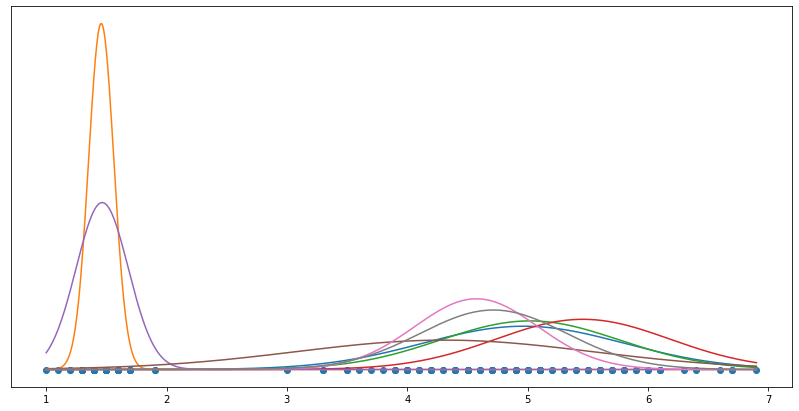

9 460.58305490346527


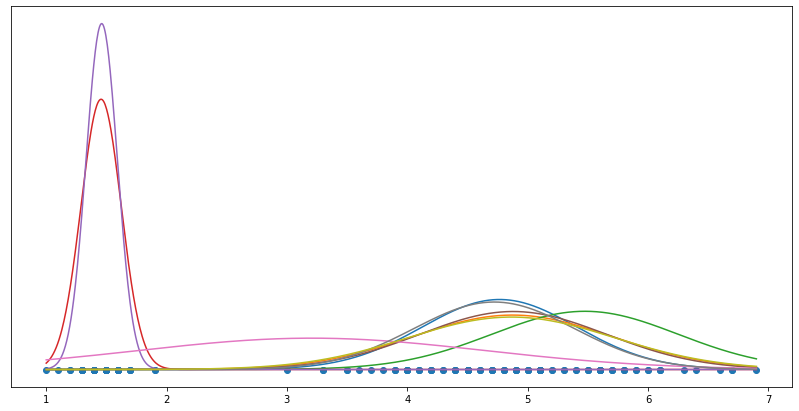

10 474.8284639840887


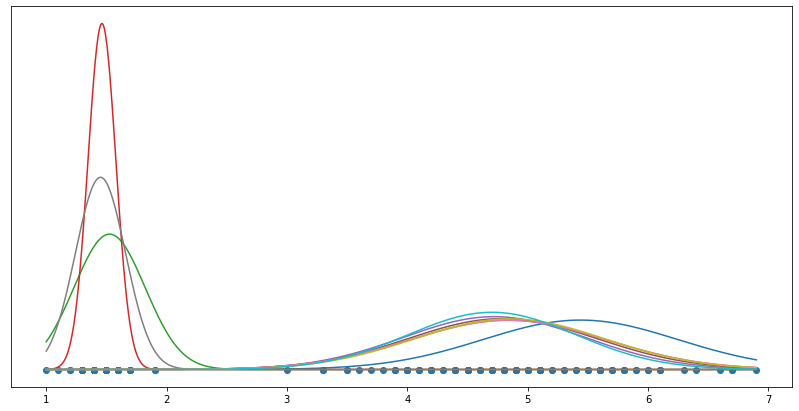

11 472.0301583458249


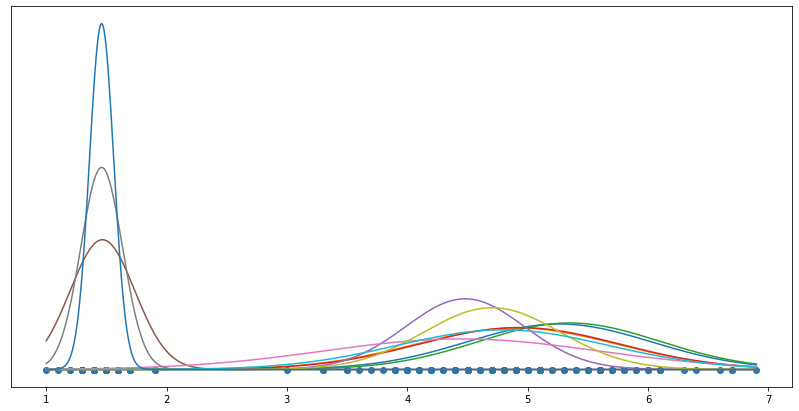

12 473.9766825179024


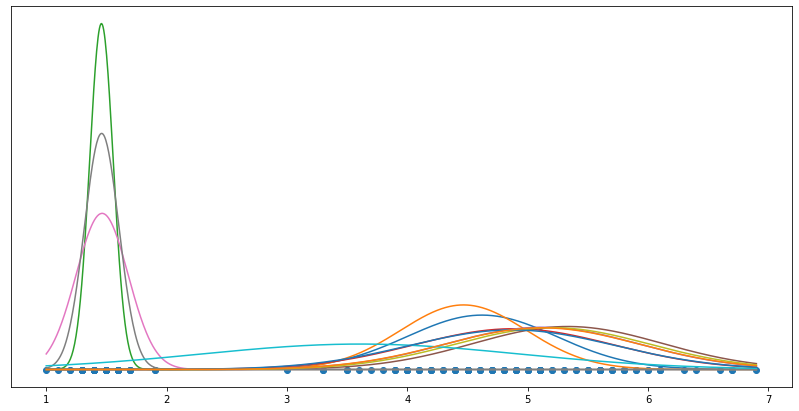

13 492.40515462451395


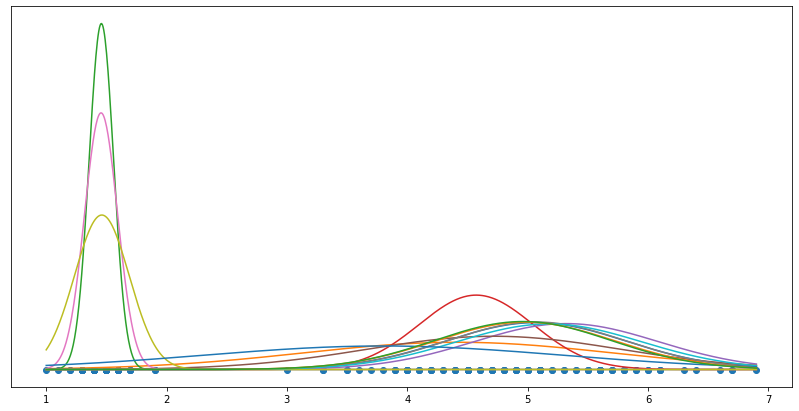

14 522.0642850693896


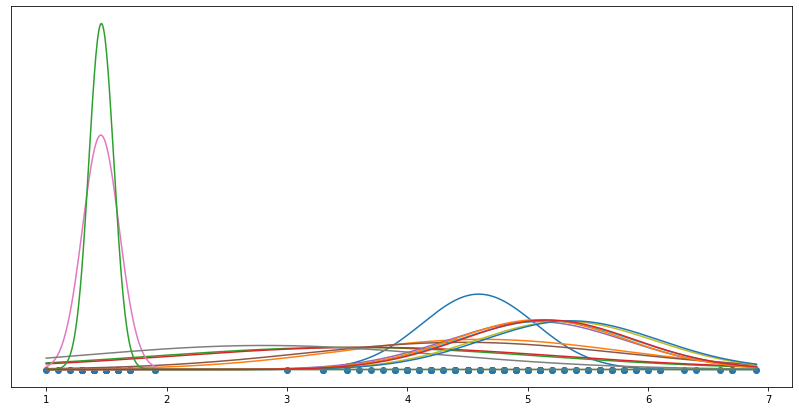

15 503.300160812056


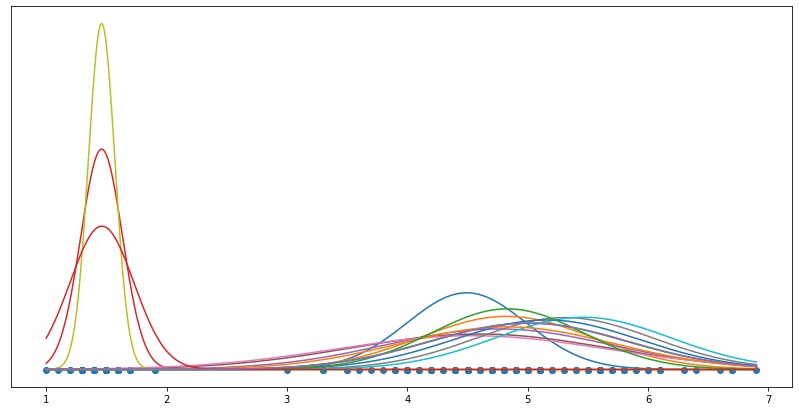

best model:


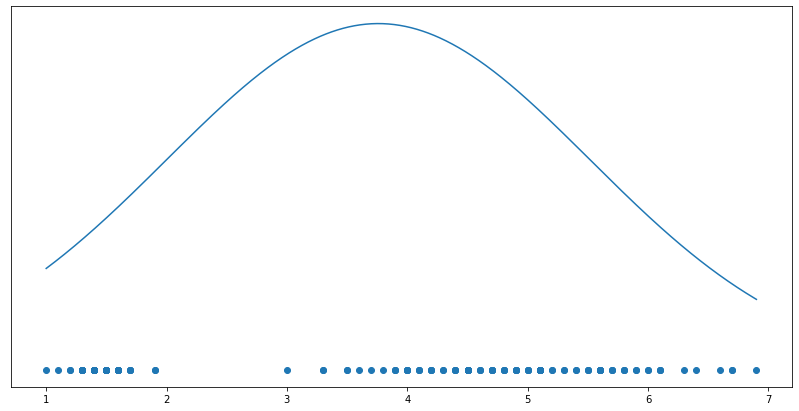

In [13]:
sel_plt(iris_x)

1 2790.4060160663075


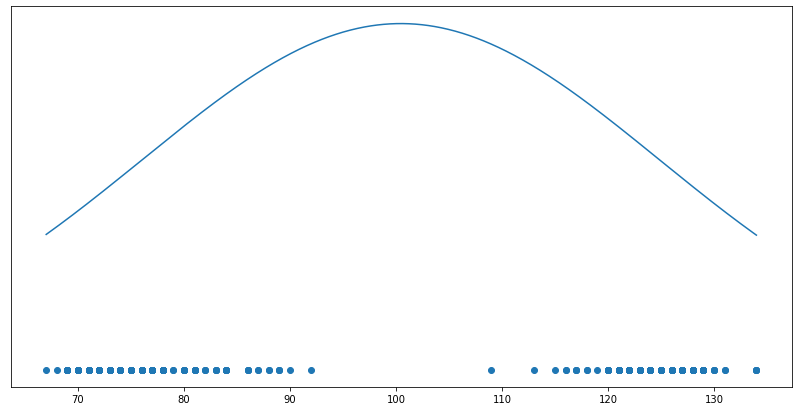

This is the new best model according to aic!
2 2267.9405440042915


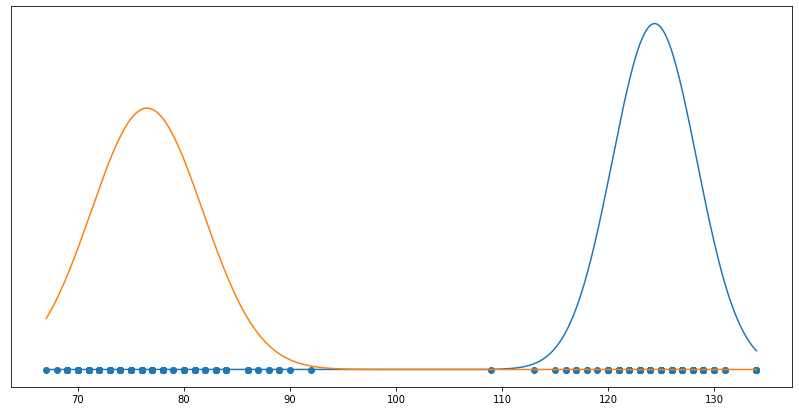

3 2231.493256476966


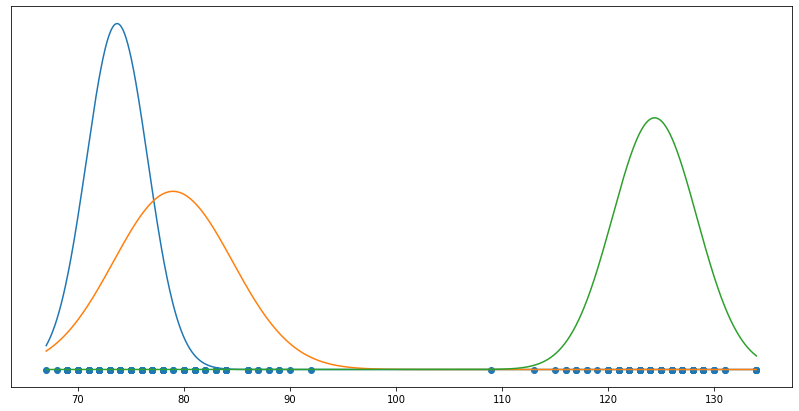

4 2271.1975290957807


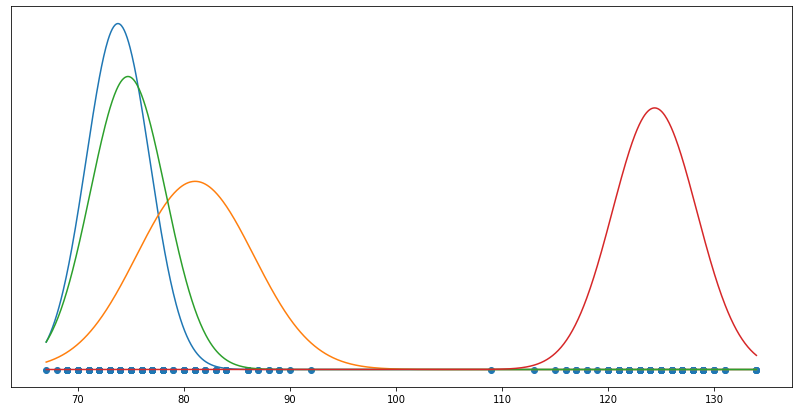

5 2210.6247599865706


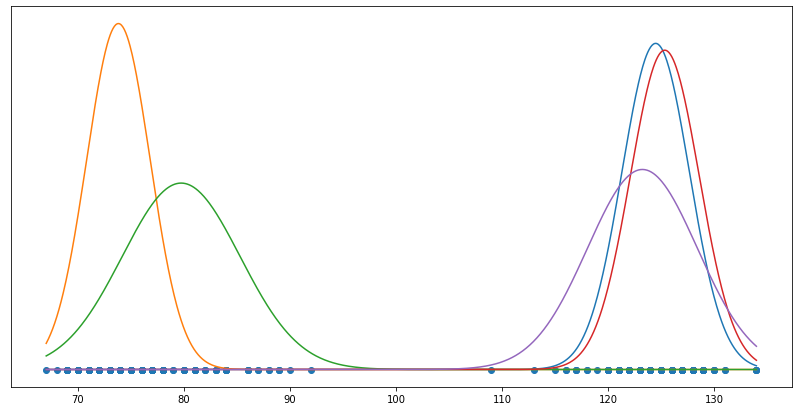

6 2278.779728412047


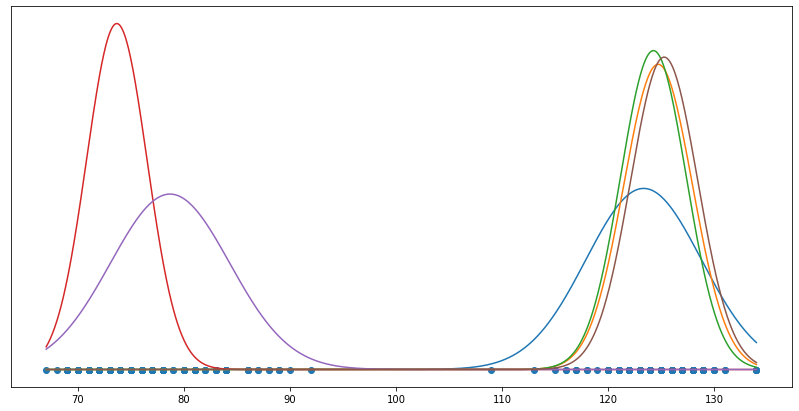

7 2214.883358863719


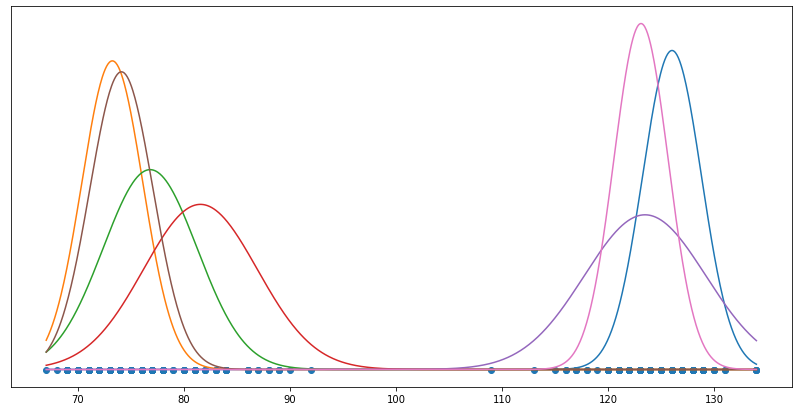

8 2215.464616862599


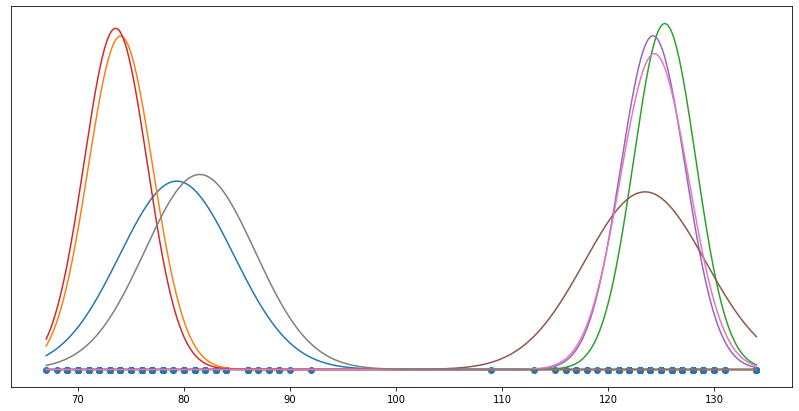

9 2245.8528569566824


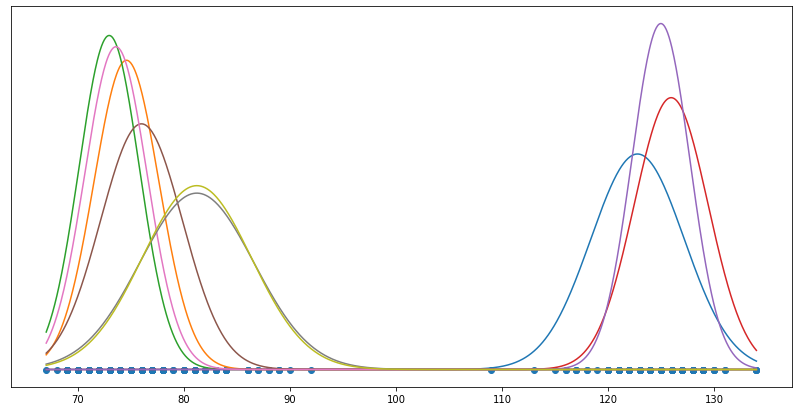

10 2226.618370683978


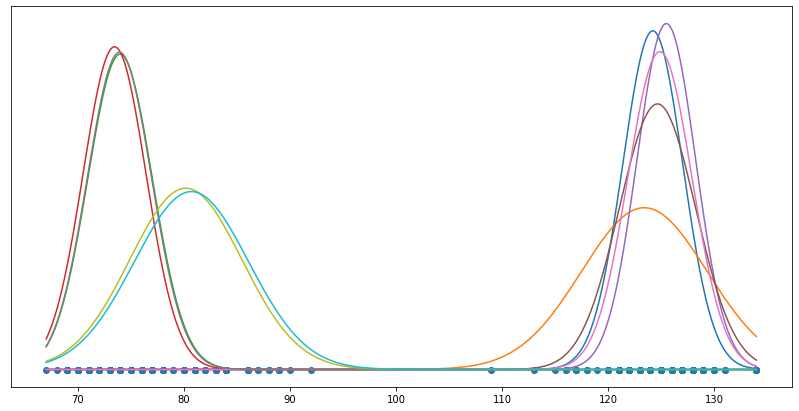

11 2251.584909318899


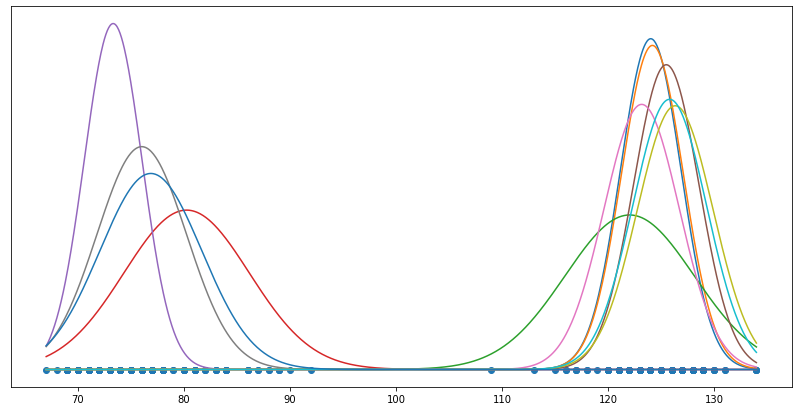

12 2259.766339000955


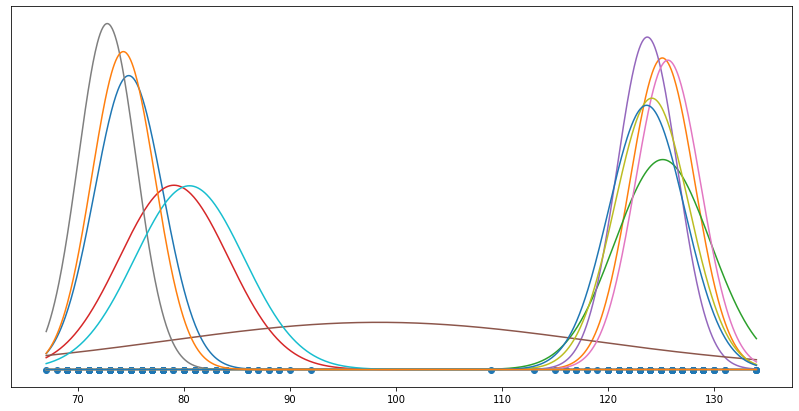

13 2285.93800071642


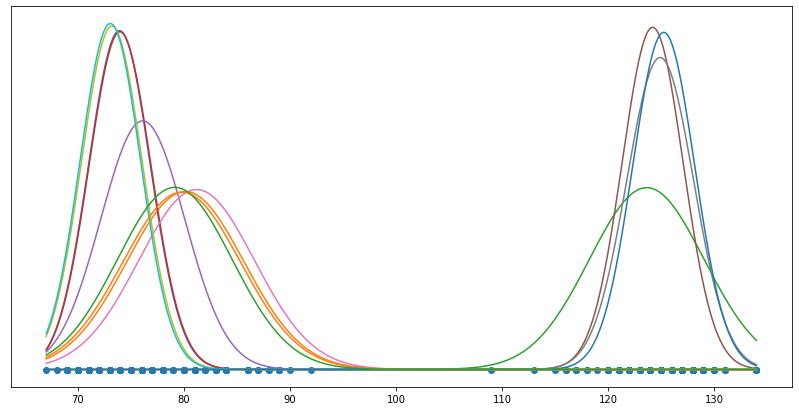

14 2251.7722116238483


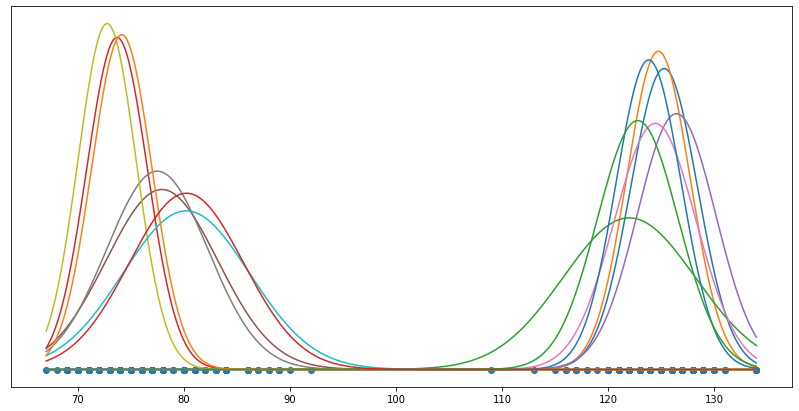

15 2257.539822830892


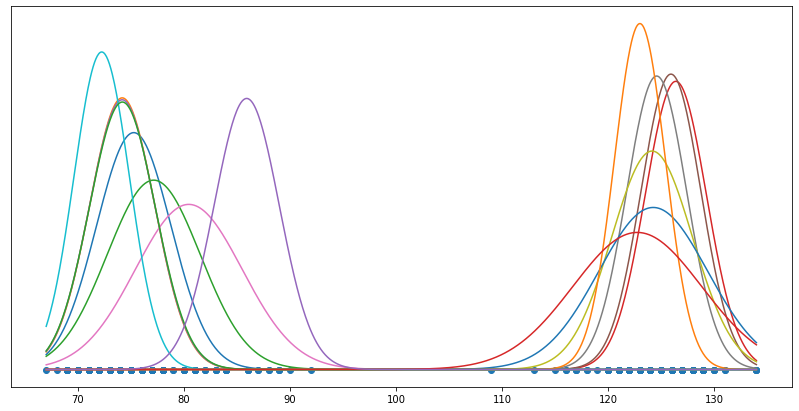

best model:


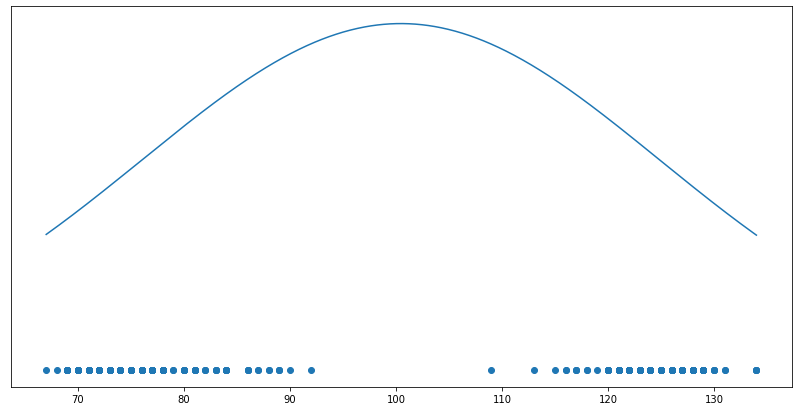

In [14]:
sel_plt(bdp_x)